In [ ]:
# Environment & imports

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info if 'failed' not in gpu_info else 'Not connected to a GPU')

!nvidia-smi -L || true
!pip -q install "transformers==4.41.2" "decord==0.6.0" "torchmetrics==1.4.0" "scikit-learn==1.5.1" --no-cache-dir

import os, math, random, json, glob, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

import decord
decord.bridge.set_bridge('native')

from transformers import (
    AutoImageProcessor,
    TimesformerModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
)

from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score


# Repro & device
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

Sun Sep 14 00:29:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    3955MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data paths

DATA_ROOT = "/content/drive/MyDrive/Moo/Annotations"  # Augmented dataset
TRAIN_DIR = os.path.join(DATA_ROOT, "train_aug")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

CLASSES = [
    "Drinking",
    "Feeding & Lying",
    "Feeding & Standing",
    "Lying",
    "Ruminating & Lying",
    "Ruminating & Standing",
    "Standing",
]
label2id = {c:i for i,c in enumerate(CLASSES)}
id2label = {i:c for c,i in label2id.items()}

# Two-head factorization
POSTURE  = {"Standing":0, "Lying":1}                          # 2 classes
ACTIVITY = {"None":0, "Drinking":1, "Feeding":2, "Ruminating":3}  # 4 classes

In [ ]:
# Hyperparams

NUM_FRAMES      = 12
IMAGE_SIZE      = 224
BATCH_SIZE      = 4
ACCUM_STEPS     = 4
EPOCHS          = 20
LR              = 3e-5
WEIGHT_DECAY    = 0.01
WARMUP_RATIO    = 0.1
MAX_GRAD_NORM   = 1.0
MIXED_PRECISION = True
PATIENCE        = 4
MIN_DELTA       = 1e-4

# Multi-task loss weights
LAMBDA_P        = 1   # posture loss weight
LAMBDA_A        = 1.2   # activity loss weight

NUM_WORKERS     = 4
CKPT            = "facebook/timesformer-base-finetuned-k400"

save_dir        = "/content/drive/MyDrive/Models/timesformer-cows-multitask"
ckpt_dir        = os.path.join(save_dir, "checkpoints")
backbone_dir    = os.path.join(save_dir, "backbone_hf")
os.makedirs(save_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

print("Classes:", label2id)
print("Data root:", DATA_ROOT)

Classes: {'Drinking': 0, 'Feeding & Lying': 1, 'Feeding & Standing': 2, 'Lying': 3, 'Ruminating & Lying': 4, 'Ruminating & Standing': 5, 'Standing': 6}
Data root: /content/drive/MyDrive/Moo/Annotations


In [ ]:
# List videos

def list_videos(root_dir, classes):
    items = []
    for cls in classes:
        cls_dir = Path(root_dir) / cls
        patterns = ["*.mp4", "*.MP4", "*.mkv", "*.MOV", "*.mov"]
        vids = []
        for p in patterns:
            vids.extend(glob.glob(str(cls_dir / p)))
        items.extend([(v, label2id[cls]) for v in vids])
    return items

train_items = list_videos(TRAIN_DIR, CLASSES)
val_items   = list_videos(VAL_DIR,   CLASSES)
print(f"Found {len(train_items)} train and {len(val_items)} val clips.")
assert len(train_items) > 0 and len(val_items) > 0

def class_counts(items):
    cnt = np.zeros(len(CLASSES), dtype=int)
    for _, y in items: cnt[y] += 1
    return dict(zip(CLASSES, cnt))
print("Train counts:", class_counts(train_items))
print("Val counts  :", class_counts(val_items))

Found 9652 train and 1119 val clips.
Train counts: {'Drinking': np.int64(1345), 'Feeding & Lying': np.int64(1232), 'Feeding & Standing': np.int64(1428), 'Lying': np.int64(1431), 'Ruminating & Lying': np.int64(1418), 'Ruminating & Standing': np.int64(1409), 'Standing': np.int64(1389)}
Val counts  : {'Drinking': np.int64(79), 'Feeding & Lying': np.int64(44), 'Feeding & Standing': np.int64(280), 'Lying': np.int64(333), 'Ruminating & Lying': np.int64(183), 'Ruminating & Standing': np.int64(101), 'Standing': np.int64(99)}


In [ ]:
# Frame sampling + decoding

def sample_indices(num_frames_in_video, num_frames_needed):
    if num_frames_in_video <= num_frames_needed:
        return np.linspace(0, num_frames_in_video-1, num_frames_needed).astype(int)
    ticks = np.linspace(0, num_frames_in_video-1, num_frames_needed+1)
    idxs = []
    for i in range(num_frames_needed):
        s = int(math.floor(ticks[i])); e = int(math.floor(ticks[i+1]))
        if e <= s: e = s + 1
        idxs.append(random.randint(s, max(s, e-1)))
    return np.array(idxs)

def decode_video(path, num_frames=NUM_FRAMES):
    try:
        vr = decord.VideoReader(path)
        if len(vr) == 0:
            raise ValueError("Empty video")
        idxs = sample_indices(len(vr), num_frames)
        batch = vr.get_batch(idxs)   # (T,H,W,C), uint8
        frames = batch.asnumpy()
    except Exception as e:
        # Fallback: black frames to avoid crashing on a single bad file
        h, w = IMAGE_SIZE, IMAGE_SIZE
        frames = np.zeros((num_frames, h, w, 3), dtype=np.uint8)
    return [frames[i] for i in range(frames.shape[0])]


In [ ]:
# Label split + Dataset / Collate

def split_label(y_idx, id2label):
    name = id2label[int(y_idx)]
    if name == "Drinking":               return POSTURE["Standing"], ACTIVITY["Drinking"]
    if name == "Feeding & Lying":        return POSTURE["Lying"],   ACTIVITY["Feeding"]
    if name == "Feeding & Standing":     return POSTURE["Standing"], ACTIVITY["Feeding"]
    if name == "Lying":                  return POSTURE["Lying"],   ACTIVITY["None"]
    if name == "Ruminating & Lying":     return POSTURE["Lying"],   ACTIVITY["Ruminating"]
    if name == "Ruminating & Standing":  return POSTURE["Standing"], ACTIVITY["Ruminating"]
    if name == "Standing":               return POSTURE["Standing"], ACTIVITY["None"]
    raise ValueError(name)

image_processor = AutoImageProcessor.from_pretrained(CKPT)

class VideoDataset(Dataset):
    def __init__(self, items):
        self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        path, label = self.items[idx]
        frames = decode_video(path, NUM_FRAMES)       # list of HWC uint8
        p,a = split_label(label, id2label)
        return {"video": frames, "label": label, "posture": p, "activity": a, "path": path}

def collate_fn(batch):
    videos   = [b["video"] for b in batch]
    labels   = torch.tensor([b["label"] for b in batch], dtype=torch.long)
    posture  = torch.tensor([b["posture"] for b in batch], dtype=torch.long)
    activity = torch.tensor([b["activity"] for b in batch], dtype=torch.long)
    proc = image_processor(images=videos, return_tensors="pt")  # (B,C,T,H,W)
    return {"pixel_values": proc["pixel_values"], "labels": labels,
            "posture": posture, "activity": activity}

def _seed_worker(worker_id):
    seed = torch.initial_seed() % 2**32
    random.seed(seed); np.random.seed(seed & 0xFFFFFFFF)

g = torch.Generator()
g.manual_seed(42)

dl_train_kwargs = dict(
    dataset=None, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0),
    collate_fn=collate_fn, drop_last=True,
    worker_init_fn=_seed_worker, generator=g
)
dl_val_kwargs = dict(
    dataset=None, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=False,
    collate_fn=collate_fn,
    worker_init_fn=_seed_worker, generator=g
)


if NUM_WORKERS > 0:
    dl_train_kwargs["prefetch_factor"] = 2
    dl_val_kwargs["prefetch_factor"] = 2

train_ds = VideoDataset(train_items)
val_ds   = VideoDataset(val_items)
train_loader = DataLoader(**{**dl_train_kwargs, "dataset": train_ds})
val_loader   = DataLoader(**{**dl_val_kwargs,   "dataset": val_ds})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

In [ ]:
# Two-head model

class MultiTaskTimeSformer(nn.Module):
    def __init__(self, ckpt):
        super().__init__()
        cfg = AutoConfig.from_pretrained(ckpt)
        self.backbone = TimesformerModel.from_pretrained(ckpt, config=cfg)
        hidden = cfg.hidden_size
        p_drop = getattr(cfg, "hidden_dropout_prob", getattr(cfg, "dropout", 0.0))
        self.dropout = nn.Dropout(p_drop)
        self.posture_head  = nn.Linear(hidden, 2)  # Standing/Lying
        self.activity_head = nn.Linear(hidden, 4)  # None/Drinking/Feeding/Ruminating
        # Optional: gradient checkpointing to save VRAM
        if hasattr(self.backbone, "gradient_checkpointing_enable"):
            self.backbone.gradient_checkpointing_enable()

    def forward(self, pixel_values):
        out = self.backbone(pixel_values=pixel_values)  # last_hidden_state: [B, tokens, H]
        cls = out.last_hidden_state[:, 0]               # CLS token
        x = self.dropout(cls)
        return self.posture_head(x), self.activity_head(x)

model = MultiTaskTimeSformer(CKPT).to(device)

# Masked joint decode: combine two heads into 7-class space
PAIR_LIST = [
    ("Standing","Drinking",  label2id["Drinking"]),
    ("Lying","Feeding",      label2id["Feeding & Lying"]),
    ("Standing","Feeding",   label2id["Feeding & Standing"]),
    ("Lying","None",         label2id["Lying"]),
    ("Lying","Ruminating",   label2id["Ruminating & Lying"]),
    ("Standing","Ruminating",label2id["Ruminating & Standing"]),
    ("Standing","None",      label2id["Standing"]),
]
def joint_decode(posture_logits, activity_logits):
    lp = F.log_softmax(posture_logits,  dim=-1)   # [B,2]
    la = F.log_softmax(activity_logits, dim=-1)   # [B,4]
    B = lp.size(0)
    joint = torch.full((B, len(CLASSES)), -1e9, device=lp.device)
    for p_str, a_str, cls_idx in PAIR_LIST:
        p = POSTURE[p_str]; a = ACTIVITY[a_str]
        joint[:, cls_idx] = lp[:, p] + la[:, a]
    preds = joint.argmax(-1)
    return preds, joint

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

In [ ]:
# Optimizer, scheduler, loss

ce_posture  = nn.CrossEntropyLoss()
ce_activity = nn.CrossEntropyLoss()

# compute real optimizer steps per epoch
batches = len(train_loader)
updates_per_epoch = (batches // ACCUM_STEPS) + (1 if (batches % ACCUM_STEPS) else 0)
num_training_steps = EPOCHS * updates_per_epoch
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)
scaler = GradScaler(enabled=(device.type == "cuda" and MIXED_PRECISION))

print(f"Training steps: {num_training_steps} (warmup {num_warmup_steps})")

/tmp/ipython-input-811256719.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda" and MIXED_PRECISION))


Training steps: 12080 (warmup 1208)


In [ ]:
# Train / Validate

history = {
    "epoch": [], "train_loss": [], "val_loss": [],
    "val_acc_joint": [], "val_f1_joint": [],
    "val_acc_posture": [], "val_acc_activity": []
}

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot_loss, n = 0.0, 0
    acc_joint = MulticlassAccuracy(num_classes=len(CLASSES)).to(device)
    f1_joint  = MulticlassF1Score(num_classes=len(CLASSES), average="macro").to(device)
    acc_pos   = MulticlassAccuracy(num_classes=2).to(device)
    acc_act   = MulticlassAccuracy(num_classes=4).to(device)

    with torch.inference_mode():
        for batch in loader:
            pv = batch["pixel_values"].to(device, non_blocking=True)
            y_pos = batch["posture"].to(device, non_blocking=True)
            y_act = batch["activity"].to(device, non_blocking=True)
            y7    = batch["labels"].to(device, non_blocking=True)

            pos_logits, act_logits = model(pv)
            loss = (LAMBDA_P * ce_posture(pos_logits, y_pos) +
                    LAMBDA_A * ce_activity(act_logits, y_act))
            tot_loss += loss.item() * y7.size(0); n += y7.size(0)

            _, joint_log = joint_decode(pos_logits, act_logits)
            acc_joint.update(joint_log, y7)   # torchmetrics accepts logits
            f1_joint.update(joint_log, y7)
            acc_pos.update(pos_logits, y_pos)
            acc_act.update(act_logits, y_act)

    return (tot_loss / max(1,n),
            float(acc_joint.compute().item()),
            float(f1_joint.compute().item()),
            float(acc_pos.compute().item()),
            float(acc_act.compute().item()))

def metric_score(val_loss, val_acc_joint, val_f1_joint, prefer="val_f1"):
    if prefer == "val_loss": return -val_loss
    if prefer == "val_acc":  return val_acc_joint
    return val_f1_joint

best_score = -float("inf")
stale = 0
best_joint_f1 = 0.0
backbone_saved_once = False

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, ntrain = 0.0, 0
    optimizer.zero_grad(set_to_none=True)
    t0 = time.time()

    for step, batch in enumerate(train_loader, start=1):
        pv = batch["pixel_values"].to(device, non_blocking=True)
        y_pos = batch["posture"].to(device, non_blocking=True)
        y_act = batch["activity"].to(device, non_blocking=True)

        with autocast(enabled=(device.type == "cuda" and MIXED_PRECISION)):
            pos_logits, act_logits = model(pv)
            raw_loss = (LAMBDA_P * ce_posture(pos_logits, y_pos) +
                        LAMBDA_A * ce_activity(act_logits, y_act))
            loss = raw_loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        # Step on accumulation boundary
        if step % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        # Log the raw loss for comparability with val_loss
        running_loss += raw_loss.item() * pv.size(0)
        ntrain += pv.size(0)

    # Flush leftover grads if batches not multiple of ACCUM_STEPS
    if (len(train_loader) % ACCUM_STEPS) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        scaler.step(optimizer); scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    # Validation
    val_loss, val_acc_joint, val_f1_joint, val_acc_pos, val_acc_act = evaluate(model, val_loader)
    train_loss = running_loss / max(1, ntrain)
    dt = time.time() - t0

    print(f"Epoch {epoch:02d}/{EPOCHS}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"joint_acc={val_acc_joint:.4f}  joint_f1={val_f1_joint:.4f}  "
          f"pos_acc={val_acc_pos:.4f}  act_acc={val_acc_act:.4f}  ({dt/60:.1f} min)")

    # Save history
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc_joint"].append(val_acc_joint)
    history["val_f1_joint"].append(val_f1_joint)
    history["val_acc_posture"].append(val_acc_pos)
    history["val_acc_activity"].append(val_acc_act)
    pd.DataFrame(history).to_csv(os.path.join(save_dir, "training_history_multitask.csv"), index=False)

    # Save every epoch
    epoch_path = os.path.join(ckpt_dir, f"epoch_{epoch:03d}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "ckpt": backbone_dir if backbone_saved_once and os.path.isdir(backbone_dir) else CKPT,
        "POSTURE": POSTURE, "ACTIVITY": ACTIVITY,
        "label2id": label2id, "id2label": id2label,
        "num_frames": NUM_FRAMES, "image_size": IMAGE_SIZE
    }, epoch_path)
    # also keep a rolling "last"
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "ckpt": backbone_dir if backbone_saved_once and os.path.isdir(backbone_dir) else CKPT,
        "label2id": label2id, "id2label": id2label,
        "num_frames": NUM_FRAMES
    }, os.path.join(save_dir, "last_multitask.pt"))

    # Save BEST by joint macro-F1 + backbone HF-format
    if val_f1_joint > best_joint_f1:
        best_joint_f1 = val_f1_joint

        # 1) Save composite (heads+backbone refs)
        torch.save({
            "model_state_dict": model.state_dict(),
            "ckpt": backbone_dir if backbone_saved_once and os.path.isdir(backbone_dir) else CKPT,
            "POSTURE": POSTURE, "ACTIVITY": ACTIVITY,
            "label2id": label2id, "id2label": id2label,
            "num_frames": NUM_FRAMES, "image_size": IMAGE_SIZE
        }, os.path.join(save_dir, "best_multitask.pt"))

        # 2) Ensure HF-format backbone is saved ONCE
        if not backbone_saved_once:
            os.makedirs(backbone_dir, exist_ok=True)
            model.backbone.save_pretrained(backbone_dir)   # -> config.json + model.safetensors/bin
            image_processor.save_pretrained(backbone_dir)  # -> preprocessor_config.json
            with open(os.path.join(backbone_dir, "labels.json"), "w") as f:
                json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)
            backbone_saved_once = True

        print(f"✅ Saved new best (joint F1={val_f1_joint:.4f}) to {save_dir}")

    # Early stopping
    score = metric_score(val_loss, val_acc_joint, val_f1_joint, prefer="val_f1")
    if score > best_score + MIN_DELTA:
        best_score = score; stale = 0
    else:
        stale += 1
        if stale >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

print("Training complete.")

/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 01/20  train_loss=1.1272  val_loss=0.6991  joint_acc=0.7338  joint_f1=0.7386  pos_acc=0.9928  act_acc=0.7359  (43.5 min)
✅ Saved new best (joint F1=0.7386) to /content/drive/MyDrive/Models/timesformer-cows-multitask


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 02/20  train_loss=0.3915  val_loss=0.6721  joint_acc=0.8226  joint_f1=0.8071  pos_acc=0.9928  act_acc=0.8456  (22.8 min)
✅ Saved new best (joint F1=0.8071) to /content/drive/MyDrive/Models/timesformer-cows-multitask


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 03/20  train_loss=0.2394  val_loss=0.7253  joint_acc=0.8147  joint_f1=0.8045  pos_acc=0.9928  act_acc=0.8416  (23.0 min)


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 04/20  train_loss=0.1291  val_loss=1.0163  joint_acc=0.8126  joint_f1=0.7992  pos_acc=0.9928  act_acc=0.8546  (22.9 min)


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 05/20  train_loss=0.0889  val_loss=0.9548  joint_acc=0.8194  joint_f1=0.8224  pos_acc=0.9946  act_acc=0.8327  (22.8 min)
✅ Saved new best (joint F1=0.8224) to /content/drive/MyDrive/Models/timesformer-cows-multitask


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 06/20  train_loss=0.0511  val_loss=1.1530  joint_acc=0.8397  joint_f1=0.8353  pos_acc=0.9937  act_acc=0.8510  (23.0 min)
✅ Saved new best (joint F1=0.8353) to /content/drive/MyDrive/Models/timesformer-cows-multitask


/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

Epoch 07/20  train_loss=0.0470  val_loss=1.1590  joint_acc=0.8482  joint_f1=0.8386  pos_acc=0.9937  act_acc=0.8756  (23.0 min)
✅ Saved new best (joint F1=0.8386) to /content/drive/MyDrive/Models/timesformer-cows-multitask


KeyboardInterrupt: 

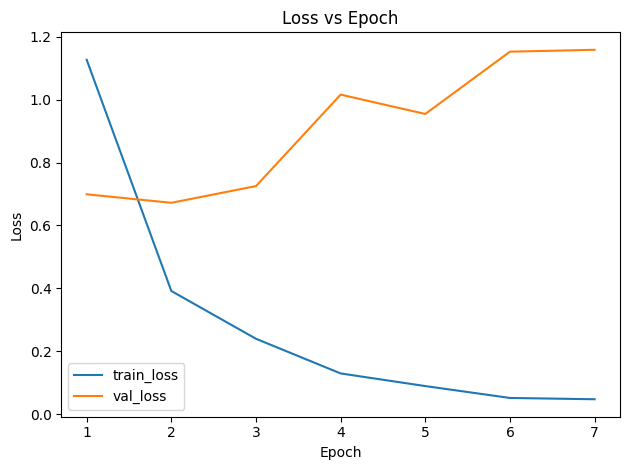

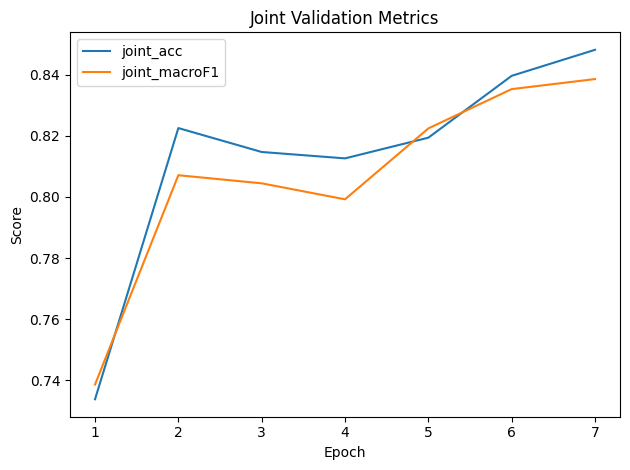

In [ ]:
# Curves

hist_df = pd.DataFrame(history)

plt.figure()
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train_loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val_loss")
plt.title("Loss vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=150); plt.show()

plt.figure()
plt.plot(hist_df["epoch"], hist_df["val_acc_joint"], label="joint_acc")
plt.plot(hist_df["epoch"], hist_df["val_f1_joint"], label="joint_macroF1")
plt.title("Joint Validation Metrics"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "metrics_curve.png"), dpi=150); plt.show()

/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(value)
/usr/local/lib/python3.12/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.arr

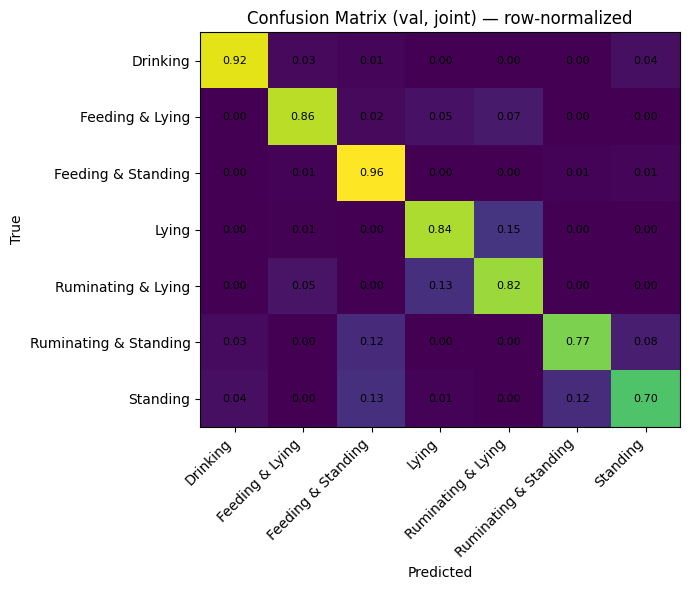

,precision,recall,f1-score,support
Drinking,0.912500,0.924051,0.918239,79.000000
Feeding & Lying,0.703704,0.863636,0.775510,44.000000
Feeding & Standing,0.909091,0.964286,0.935875,280.000000
Lying,0.912338,0.843844,0.876755,333.000000
Ruminating & Lying,0.742574,0.819672,0.779221,183.000000
Ruminating & Standing,0.829787,0.772277,0.800000,101.000000
Standing,0.821429,0.696970,0.754098,99.000000
accuracy,0.857015,0.857015,0.857015,0.857015
macro avg,0.833060,0.840677,0.834243,1119.000000
weighted avg,0.860076,0.857015,0.856766,1119.000000


AP[Drinking] = 96.16%
AP[Feeding & Lying] = 85.51%
AP[Feeding & Standing] = 97.47%
AP[Lying] = 95.14%
AP[Ruminating & Lying] = 81.44%
AP[Ruminating & Standing] = 82.76%
AP[Standing] = 81.91%

==> Joint mAP (macro) on val: 88.63%


In [ ]:
# Confusion matrix + report

@torch.no_grad()
def collect_joint_predictions(loader):
    model.eval()
    all_joint_logits, all_labels = [], []
    for batch in loader:
        try:
            pv   = batch["pixel_values"].to(device, non_blocking=True)
            y7   = batch["labels"].to(device, non_blocking=True)
            pos_logits, act_logits = model(pv)
            _, joint_log = joint_decode(pos_logits, act_logits)
            all_joint_logits.append(joint_log.cpu())
            all_labels.append(y7.cpu())
        except Exception as e:
            print(f"Error processing batch: {e}")
            # Optionally, you can add more details from the batch if available,
            # but be careful not to print sensitive or very large data.
            continue # Skip this batch and continue with the next

    if not all_joint_logits:
        print("No data collected. Cannot compute metrics.")
        return None, None, None

    joint_logits = torch.cat(all_joint_logits, dim=0).numpy()
    y_true = torch.cat(all_labels, dim=0).numpy()
    probs = torch.softmax(torch.tensor(joint_logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return probs, preds, y_true

y_scores, y_pred, y_true = collect_joint_predictions(val_loader)

if y_scores is not None:
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
    cm_norm = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)

    plt.figure(figsize=(7,6))
    plt.imshow(cm_norm, aspect="auto")
    plt.title("Confusion Matrix (val, joint) — row-normalized")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(ticks=np.arange(len(CLASSES)), labels=CLASSES, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(CLASSES)), labels=CLASSES)
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", fontsize=8)
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "confusion_matrix_joint.png"), dpi=150); plt.show()

    report = classification_report(y_true, y_pred, target_names=CLASSES, digits=3, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(save_dir, "classification_report_joint.csv"))
    display(report_df)

    # mAP (macro) over joint 7-class
    num_classes = len(CLASSES)
    y_true_bin = np.eye(num_classes)[y_true]
    aps = []
    for c in range(num_classes):
        ap_c = average_precision_score(y_true_bin[:, c], y_scores[:, c])
        aps.append(ap_c)
        print(f"AP[{CLASSES[c]}] = {100*ap_c:.2f}%")
    mAP_macro = float(np.mean(aps))
    print(f"\n==> Joint mAP (macro) on val: {100*mAP_macro:.2f}%")
    pd.DataFrame({"class": CLASSES, "AP": aps, "AP_%": [100*a for a in aps]}).to_csv(
        os.path.join(save_dir, "per_class_AP_joint.csv"), index=False
    )